##  Goal: predicting the class of a text.
### Task: Fine-tune a BERT model for sequence classification.


#### BERT-HuggingFace workflow:
#### 1- Divide your data into training and test sets.
#### 2- Encode your data into a format BERT will understand.
#### 3- Combine your data and labels into dataset objects.
#### 4- Load the pre-trained BERT model.
#### 5- Fine-tune the model using your training data.
#### 6- Predict new labels and evaluate performance on your test data.

In [1]:
!pip3 install transformers
# !pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from collections import defaultdict
import gdown
import gzip
import json
import random
import pickle

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

In [4]:
# add shortcut to drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Data_Goodreads

/content/drive/MyDrive/Data_Goodreads


 ## Goodreads data

In [ ]:
def load_reviews(file_name,
                 head=None):

    reviews = []
    count = 0

    with gzip.open(file_name) as file:   # gzip to unzip the downloaded JSON files 
        for line in file:

            d = json.loads(line)         # json to load the JSON files once they're unzipped
            count += 1

            _book_id = d['book_id']

            reviews.append(d['review_text'])

            # Break if we reach the Nth line
            if (head is not None) and (count > head):
                break

    return reviews

In [ ]:
genres = ['poetry', 'children', 'comics_graphic', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'romance', 'young_adult']
genre_reviews_dict = {}

for _genre in genres:
    print('Loading ' + _genre + '.json.gz')
    _reviews = load_reviews(_genre + '.json.gz')
    genre_reviews_dict[_genre] = random.sample(_reviews, 2000)

In [ ]:
for _genre, _reviews in genre_reviews_dict.items():
    print('===========================')
    print(_genre)
    print('===========================')
    print(random.sample(_reviews, 1)[0])
    print()

poetry
The third time I read it. "The Gospel according to Brady!...Brady, Brady, Almighty!"

children
Originally Posted Here 
 Jake and Lily have been together ever since they were babies, they experience each other's feelings and every night on their birthday the both sleepwalk to a train station. So when their parents suggest that it's time to make some friends and have their separate rooms, Lily's not happy; Jake doesn't really care. But once Jake makes some friends, he forgets about Lily, and is suddenly mean to her. Lily's alone, she has no friends to hang out with and she misses the old Jake. Will the twins ever be the same? Or together again? 
 Jerry Spinelli has done it again! In his funny new novel, Mr. Spinelli gives you a story written from both Jake and Lily's point of view. Judging from the synopsis on the back, I immediately thought I would love Jake not Lily. As a matter of fact, I kept on thinking, come on Lily get a life, but towards the middle my feelings changed. I b

In [4]:
#pickle.dump(genre_reviews_dict, open('genre_reviews_dict.pickle', 'wb'))
genre_reviews_dict = pickle.load(open('genre_reviews_dict.pickle', 'rb'))

In [5]:
# dictionary with key "romance, poetry...etc" and value = text
print(len(genre_reviews_dict))
genre_reviews_dict.keys()

8


dict_keys(['poetry', 'children', 'comics_graphic', 'fantasy_paranormal', 'history_biography', 'mystery_thriller_crime', 'romance', 'young_adult'])

## Training and Test sets

In [6]:
train_texts = []
train_labels = []

test_texts = []
test_labels = []

for _genre, _reviews in genre_reviews_dict.items():

    _reviews = random.sample(_reviews, 1000) # Use a very small set as an example.
  
    for _review in _reviews[:800]:
        train_texts.append(_review)
        train_labels.append(_genre)
    for _review in _reviews[800:]:
        test_texts.append(_review)
        test_labels.append(_genre)

In [7]:
print("Train set: number of texts ", len(train_texts), "labels", len(train_labels))
print("Test set: number of texts ", len(test_texts), "labels", len(test_labels))

Train set: number of texts  6400 labels 6400
Test set: number of texts  1600 labels 1600


In [8]:
train_labels[0], train_texts[0]

('poetry',
 'This is the best so far. \n Beat up the Poor \n By Charles Baudelaire \n \'For two weeks I had shut myself up in my room, and I had surrounded myself with the books fashionable at that time (sixteen or seventeen years ago); I speak of books dealing with the art of making nations happy, wise, and rich, in twenty-four hours. I had thus digested -- swallowed, I mean -- all the ramblings of all those managers of public happiness -- of those who advise all the poor to become slaves, and those who persuade them that they are all dethroned kings. -- It will not be considered surprising that I was then in a state of mind bordering on vertigo or idiocy. \n Yet I thought that I sensed, shut deep within my intellect, the dim seed of an idea better than all the old wives\' formulas I had recently perused in the encyclopedia. But it was only the idea of an idea, something infinitely hazy. \n Then I went out quite thirsty. For a passionate craving for shoddy books begets a proportional 

## Baseline model

In [9]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [10]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [11]:
print(classification_report(test_labels, predictions))

                        precision    recall  f1-score   support

              children       0.55      0.58      0.56       200
        comics_graphic       0.51      0.56      0.53       200
    fantasy_paranormal       0.36      0.33      0.34       200
     history_biography       0.50      0.42      0.46       200
mystery_thriller_crime       0.47      0.42      0.45       200
                poetry       0.55      0.68      0.61       200
               romance       0.44      0.43      0.44       200
           young_adult       0.36      0.36      0.36       200

              accuracy                           0.47      1600
             macro avg       0.47      0.47      0.47      1600
          weighted avg       0.47      0.47      0.47      1600



## Texts and labels for BERT


In [12]:
# BERT model: DistilBERT to save space (it's a distilled version of the full BERT model)
model_name = 'distilbert-base-cased'  

# Name of the program management system for NVIDIA GPUs.
device_name = 'cuda'       

# Maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# Directory where we'll save our model.
cached_model_directory_name = '/content/drive/MyDrive/Data_Goodreads/results' 

In [13]:
# Labels turned into integers.
# Texts needs to be truncated/padded (512 tokens).
# Tokens separated into "word pieces" and matched to their embedding vectors.
# Add special tokens: [CLS], [SEP], [PAD], [##]
# Less frequent words will be split into two or more pieces. (prefix ##)

In [14]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

### Labels

In [15]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [16]:
label2id
# label2id.keys()
# label2id.values()
# label2id['poetry']

{'history_biography': 0,
 'romance': 1,
 'poetry': 2,
 'mystery_thriller_crime': 3,
 'fantasy_paranormal': 4,
 'children': 5,
 'young_adult': 6,
 'comics_graphic': 7}

In [17]:
id2label
#id2label.keys()
#id2label.values()
#id2label[0]

{0: 'history_biography',
 1: 'romance',
 2: 'poetry',
 3: 'mystery_thriller_crime',
 4: 'fantasy_paranormal',
 5: 'children',
 6: 'young_adult',
 7: 'comics_graphic'}

### Encode texts and labels

In [18]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [19]:
# Training Goodreads review example after encoding

' '.join(train_encodings[3].tokens[0:100])

"[CLS] The illustration in this book is definitely worth 5 stars - - it is absolutely gorgeous ! I really don ' t know if I ' ve ever seen such beautiful illustrations . My niece picked it up at the library and I made her check it out after g ##lim ##ps ##ing the pages as she turned through it . Then she went home and I kept it to read for myself . The writing , though , I would give 3 stars or maybe even 2 , so I ' m com ##p ##rom ##ising with the"

In [20]:
train_texts[3]

'The illustration in this book is definitely worth 5 stars--it is absolutely gorgeous! I really don\'t know if I\'ve ever seen such beautiful illustrations. My niece picked it up at the library and I made her check it out after glimpsing the pages as she turned through it. Then she went home and I kept it to read for myself. \n The writing, though, I would give 3 stars or maybe even 2, so I\'m compromising with the overall review. Some of it I liked; most of it was only okay, and some of it bothered me--like how the poor rhinoceros gets the only negative poem in the book. What\'s that about? \n A horn stuck on a boot-like face, \n So wrong, so clearly out of place. \n A frightful sight, preposterous-- \n it must be a Rhinoceros! \n I was also bugged by inconsistencies: the meter sometimes changes mid-poem, so they don\'t have a good rhythm; some are titled, like "The Panda," "The Wolf," and "The Giraffe," but in some the animal\'s name is just incorporated into the text, like with the 

In [21]:
# # Test Goodreads review example

' '.join(train_encodings[3].tokens[0:512])

'[CLS] The illustration in this book is definitely worth 5 stars - - it is absolutely gorgeous ! I really don \' t know if I \' ve ever seen such beautiful illustrations . My niece picked it up at the library and I made her check it out after g ##lim ##ps ##ing the pages as she turned through it . Then she went home and I kept it to read for myself . The writing , though , I would give 3 stars or maybe even 2 , so I \' m com ##p ##rom ##ising with the overall review . Some of it I liked ; most of it was only okay , and some of it bothered me - - like how the poor r ##hino ##cer ##os gets the only negative poem in the book . What \' s that about ? A horn stuck on a boot - like face , So wrong , so clearly out of place . A f ##right ##ful sight , pre ##post ##ero ##us - - it must be a R ##hino ##cer ##os ! I was also bug ##ged by in ##con ##sist ##encies : the meter sometimes changes mid - poem , so they don \' t have a good rhythm ; some are titled , like " The Pan ##da , " " The Wolf ,

In [22]:
test_texts[0]

'Great poetry. Really erotic in some parts. Jill keeps it real.'

In [23]:
' '.join(test_encodings[0].tokens[0:512])

'[CLS] Great poetry . Really erotic in some parts . Jill keeps it real . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [24]:
# training labels

set(train_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

In [25]:
# test labels

set(test_labels_encoded)

{0, 1, 2, 3, 4, 5, 6, 7}

## Torch dataset

In [26]:
#print(train_encodings[0].tokens, train_encodings[0].ids, train_encodings[0].attention_mask)
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [27]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [28]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [60]:
train_dataset.encodings[3]
#train_dataset.labels[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [34]:
# Training example in the Torch dataset 

' '.join(train_dataset.encodings[3].tokens[0:])

'[CLS] The illustration in this book is definitely worth 5 stars - - it is absolutely gorgeous ! I really don \' t know if I \' ve ever seen such beautiful illustrations . My niece picked it up at the library and I made her check it out after g ##lim ##ps ##ing the pages as she turned through it . Then she went home and I kept it to read for myself . The writing , though , I would give 3 stars or maybe even 2 , so I \' m com ##p ##rom ##ising with the overall review . Some of it I liked ; most of it was only okay , and some of it bothered me - - like how the poor r ##hino ##cer ##os gets the only negative poem in the book . What \' s that about ? A horn stuck on a boot - like face , So wrong , so clearly out of place . A f ##right ##ful sight , pre ##post ##ero ##us - - it must be a R ##hino ##cer ##os ! I was also bug ##ged by in ##con ##sist ##encies : the meter sometimes changes mid - poem , so they don \' t have a good rhythm ; some are titled , like " The Pan ##da , " " The Wolf ,

## Load the pretrained-model

In [61]:
# The model_name needs to match the name used for the tokenizer above.

model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

## BERT fine-tuning parameters --> HuggingFace

In [66]:
training_args = TrainingArguments(
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

using `logging_steps` to initialize `eval_steps` to 100
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [67]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
  }

In [68]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function 
)

In [69]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6400
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 400
  Number of trainable parameters = 65787656


Step,Training Loss,Validation Loss,Accuracy
100,1.286400,1.424524,0.518750
200,0.895900,1.484003,0.490625
300,1.084600,1.358238,0.521875
400,1.363500,1.313078,0.526250


***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20
***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=400, training_loss=1.1576005554199218, metrics={'train_runtime': 391.4545, 'train_samples_per_second': 16.349, 'train_steps_per_second': 1.022, 'total_flos': 847882066329600.0, 'train_loss': 1.1576005554199218, 'epoch': 1.0})

In [70]:
trainer.save_model(cached_model_directory_name)

Saving model checkpoint to /content/drive/MyDrive/Data_Goodreads/results
Configuration saved in /content/drive/MyDrive/Data_Goodreads/results/config.json
Model weights saved in /content/drive/MyDrive/Data_Goodreads/results/pytorch_model.bin


In [83]:
# To evaluate you can use your saved model

#trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)

## Evaluate

In [71]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1600
  Batch size = 20


{'eval_loss': 1.3130782842636108,
 'eval_accuracy': 0.52625,
 'eval_runtime': 24.8032,
 'eval_samples_per_second': 64.508,
 'eval_steps_per_second': 3.225,
 'epoch': 1.0}

In [72]:
predicted_results = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1600
  Batch size = 20


In [73]:
predicted_results.predictions.shape

(1600, 8)

In [74]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the index -> highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [75]:
len(predicted_labels)

1600

In [76]:
print(classification_report(test_labels, predicted_labels))

                        precision    recall  f1-score   support

              children       0.64      0.67      0.65       200
        comics_graphic       0.65      0.60      0.63       200
    fantasy_paranormal       0.40      0.40      0.40       200
     history_biography       0.61      0.52      0.56       200
mystery_thriller_crime       0.44      0.57      0.50       200
                poetry       0.68      0.72      0.70       200
               romance       0.45      0.51      0.48       200
           young_adult       0.31      0.20      0.25       200

              accuracy                           0.53      1600
             macro avg       0.52      0.53      0.52      1600
          weighted avg       0.52      0.53      0.52      1600



# Correct and Incorrect classifications

In [77]:
# Correct

for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 10):
    if _true_label == _predicted_label:
        print('LABEL:', _true_label)
        print('REVIEW TEXT:', _text[:100], '...')
        print()

LABEL: poetry
REVIEW TEXT: Got this as part of a poetry exchange today in the mail. As a graduate of Naropa and casual scholar  ...

LABEL: comics_graphic
REVIEW TEXT: I grabbed this book because I love graphic novels--- and had done a report in the 5th grade on Dian  ...

LABEL: comics_graphic
REVIEW TEXT: -Ik vind de 'nieuwe' Batman van Frank Miller best een verbetering. 
 -Het verhaal rondom de Joker is ...

LABEL: children
REVIEW TEXT: Why are the Boxcar Children so resourceful? Why doesn't their grandfather get along with their paren ...



In [78]:
# Incorrect

for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 10):
    if _true_label != _predicted_label:
        print('TRUE LABEL:', _true_label)
        print('PREDICTED LABEL:', _predicted_label)
        print('REVIEW TEXT:', _text[:100], '...')
        print()

TRUE LABEL: romance
PREDICTED LABEL: mystery_thriller_crime
REVIEW TEXT: Con esta ya son dos las novelas de esta autora que he tenido el placer de leer. A diferencia de Sent ...

TRUE LABEL: young_adult
PREDICTED LABEL: fantasy_paranormal
REVIEW TEXT: Kiera's been missing for a year. Zakk and his people have been searching for her everywhere. On Eart ...

TRUE LABEL: romance
PREDICTED LABEL: history_biography
REVIEW TEXT: ** spoiler alert ** 
 The first thing I'm going to say is that I didn't finish this book. I got to a ...

TRUE LABEL: poetry
PREDICTED LABEL: history_biography
REVIEW TEXT: Ben Jonson must have been a remarkable man, a true Renaissance man of letters and action who lived a ...

TRUE LABEL: comics_graphic
PREDICTED LABEL: children
REVIEW TEXT: An interesting story that does not flow in the usual vein of children's books having a moral or a ha ...



In [79]:
# Heatmaps to examine misclassification

genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
    genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
    dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

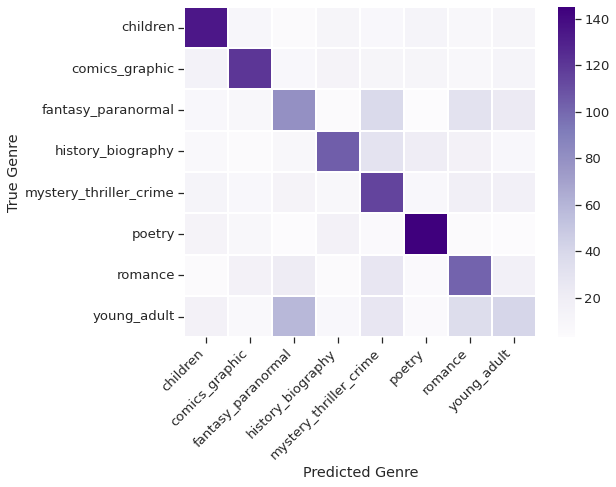

In [80]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [81]:
# Remove the diagonal from the plot to highlight the misclassifications

genre_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
    if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
        genre_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in genre_classifications_dict.items():
    dicts_to_plot.append({'True Genre': _true_genre,
                        'Predicted Genre': _predicted_genre,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Genre', 
                                 columns='Predicted Genre', 
                                 values='Number of Classifications')

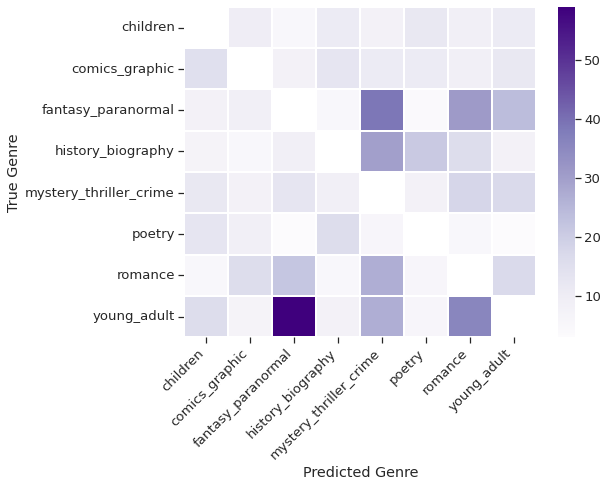

In [82]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()